### Import odpowiednich bibliotek

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt, cm as mpl_cm
import seaborn as sns
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo 
from Bio.Align import PairwiseAligner
from Bio.Align import substitution_matrices
from matplotlib import ticker
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from sklearn import manifold, datasets

from sklearn.cluster import AgglomerativeClustering
import networkx as nx

### 1. Wczytaj pobrane dane jako pandas dataframe

In [2]:
df = pd.read_csv("10k_PBMC_5pv2_nextgem_Chromium_Controller_10k_PBMC_5pv2_nextgem_Chromium_Controller_vdj_t_clonotypes.csv")

In [3]:
df

,clonotype_id,frequency,proportion,cdr3s_aa,cdr3s_nt,inkt_evidence,mait_evidence
0,clonotype1,27,0.005918,TRB:CASSFGNTIYF;TRA:CAYLLGTYKYIF,TRB:TGTGCCAGCAGTTTTGGAAACACCATATATTTT;TRA:TGTG...,NaN,NaN
1,clonotype2,12,0.002630,TRA:CAMERGYSTLTF,TRA:TGTGCAATGGAAAGAGGATACAGCACCCTCACCTTT,NaN,NaN
2,clonotype3,11,0.002411,TRB:CASSQNRRTGGINTEAFF;TRA:CGGDDMRF,TRB:TGTGCCAGCAGCCAGAATCGCCGGACAGGTGGGATCAACACT...,NaN,NaN
3,clonotype4,10,0.002192,TRB:CASSEPGASRNEQFF;TRA:CVVSGDSSYKLIF,TRB:TGTGCCAGCAGTGAACCTGGTGCCAGTCGGAATGAGCAGTTC...,NaN,NaN
4,clonotype5,7,0.001534,TRB:CASSIDVEGLSGYTF;TRA:CIPLGVRVKAAGNKLTF;TRA:...,TRB:TGTGCCAGTAGTATAGATGTGGAGGGCCTGAGTGGCTACACC...,NaN,NaN
...,...,...,...,...,...,...,...
4277,clonotype4278,1,0.000219,TRB:CASSGPGQGRSRGYTF;TRA:CAFMKHMNTGNQFYF,TRB:TGTGCCAGCAGCGGGCCGGGACAGGGCCGATCAAGGGGCTAC...,NaN,NaN
4278,clonotype4279,1,0.000219,TRB:CASSLEAGRFAGANVLTF,TRB:TGTGCCAGCAGCTTAGAGGCTGGACGTTTCGCTGGGGCCAAC...,NaN,NaN
4279,clonotype4280,1,0.000219,TRB:CASSLGYEGVYLVGEQYF;TRA:CAAVMDSSYKLIF,TRB:TGTGCCAGCAGCTTAGGCTATGAAGGGGTTTACTTGGTGGGC...,NaN,NaN
4280,clonotype4281,1,0.000219,TRB:CASSLGLGGGAFRNYEQYF;TRA:CALHGKLQF;TRA:CAVE...,TRB:TGTGCCAGCAGCTTAGGCCTGGGCGGGGGGGCCTTCCGAAAC...,NaN,NaN


### 2. Rozdziel dane w kolumnie cdr3s_aa, tak aby powstała kolumna dla tcra oraz tcrb 

In [4]:
def tcra_return(x, subunit):
    s1 = x.split(';')
    for sx in s1:
        s = sx.split(':')
        if(s[0] == subunit):
            return s[1]        

In [5]:
df['tcra_aa'] = df['cdr3s_aa'].apply (lambda x: tcra_return(x, subunit="TRA"))
df['tcrb_aa'] = df['cdr3s_aa'].apply (lambda x: tcra_return(x, subunit="TRB"))

### 3. Dokonaj wizualizacji rozkładu długości motywów zmiennych w podjednostkach alfa oraz beta

In [6]:
def tcr_len(x):
    if(x != None):
        return(len(x))

In [7]:
df['tcra_aa_len'] = df['tcra_aa'].apply (lambda x: tcr_len(x))
df['tcrb_aa_len'] = df['tcrb_aa'].apply (lambda x: tcr_len(x))

<AxesSubplot:xlabel='tcra_aa_len', ylabel='tcrb_aa_len'>

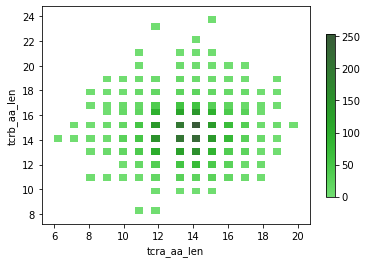

In [8]:
sns.histplot(
    df, x="tcra_aa_len", y="tcrb_aa_len",
    bins=30, cbar=True, cbar_kws=dict(shrink=.75),color='forestgreen',
)

### 4. Sprawdź jak często występują 2 wybrane aminokwasy w podjednostkach alfa i beta, zobrazuj wyniki

In [9]:
def tcr_amino_count(x, amino):
    k_count = 0
    if(x != None):
        for k in x:
            if(k==amino):
                k_count += 1
        
    return(k_count)

In [10]:
df['tcra_aa_amino_G'] = df['tcra_aa'].apply (lambda x: tcr_amino_count(x, amino='G'))
df['tcrb_aa_amino_G'] = df['tcrb_aa'].apply (lambda x: tcr_amino_count(x, amino='G'))

<AxesSubplot:xlabel='tcra_aa_amino_G', ylabel='tcrb_aa_amino_G'>

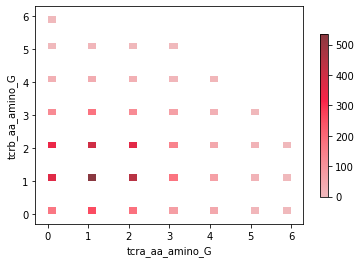

In [11]:
sns.histplot(
    df, x="tcra_aa_amino_G", y="tcrb_aa_amino_G",
    bins=30, cbar=True, cbar_kws=dict(shrink=.75),color='crimson'
)

### 5. Zaproponuj sposób wyznacznia podobieństwa między parami sekwencji CDR3 (z tcra i tcrb)

In [15]:
aligner = PairwiseAligner()
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
def tcr_alig(x, ref):
    if(x != None):
        alignments = pairwise2.align.localds(x, ref, aligner.substitution_matrix, -10, -1)
        return(alignments[0].score)

In [16]:
df["tcrb_aa"][0]

'CASSFGNTIYF'

### 6. W oparciu o zaproponowaną miarę stwórz macierz dystansu. 

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Jeśli obliczenia trają za długo, nie musisz korzystać z pełnego zbioru danych. Ogranicz zbiór danych wegle swoich potrzeb. Pamiętaj jednak, że do dalszych analiz powinien zawierać on co najmniej kilkaset receptorów. 
</div>

In [36]:
tcr_npa = df[["tcra_aa", "tcrb_aa"]].dropna().to_numpy()
dist_al_trcb = np.zeros(np.shape(tcr_npa)[0]*np.shape(tcr_npa)[0]).reshape(np.shape(tcr_npa)[0],np.shape(tcr_npa)[0])
dist_al_trcb += -1
for x in range(0,300):
    print(x)
    for y in range(0+x,300):
        dist_al_trcb[x][y] = tcr_alig(tcr_npa[x][0],tcr_npa[y][0]) + tcr_alig(tcr_npa[x][1],tcr_npa[y][1]) 
        dist_al_trcb[y][x] = dist_al_trcb[x][y] 
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [37]:
dist2 = dist_al_trcb[:300,:300]

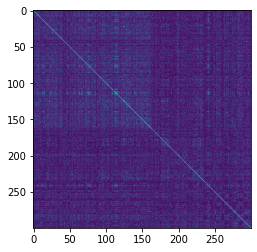

In [38]:
plt.imshow(dist2)

### 7. Dokonaj grupowania repertuaru w oparciu o wybrany algorytm klasteryzacji. Wyniki zwizualizuj.

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> sns.clustermap może być tu pomocna, za jej pomocą pokarz wyniki grupowania (np. aglomeracyjnego). Postaraj się aby liczba wynikowych grup nie była za duża (i za mała). 
</div>

In [39]:
clustering = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold =700 ).fit_predict(dist2)

c:\program files\python38\lib\site-packages\seaborn\matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


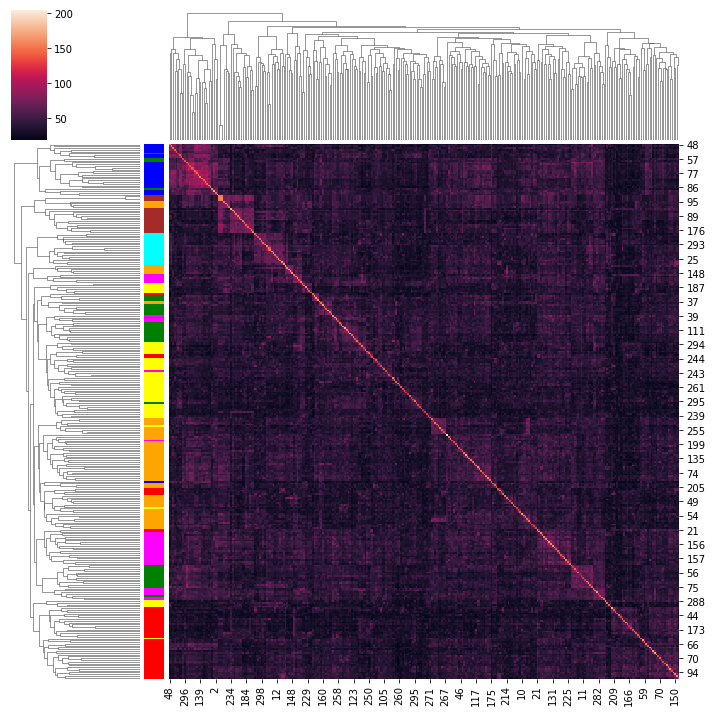

In [40]:
list(set(clustering))
lut = dict(zip(list(set(clustering)), ['red','blue','orange','magenta','yellow','green','cyan','brown']))
row_colors = np.vectorize(lut.get)(clustering)
sns.clustermap(dist2, row_colors=row_colors)

### 8. Opracuj wektor numeryczny, który odzwierciedla Twoim zdaniem dostatecznie dobrze właściwości receptora. 

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Wykorzystaj do tego celu odległość od samodzielnie dobranych sekwencji referencyjnych (prototypowych). 
</div>



In [41]:
ref_tcra = [df["tcra_aa"][41],df["tcra_aa"][550],df["tcra_aa"][3489],df["tcra_aa"][1466],df["tcra_aa"][2199]]
ref_tcrb = [df["tcrb_aa"][41],df["tcrb_aa"][550],df["tcrb_aa"][3489],df["tcrb_aa"][1466],df["tcrb_aa"][2199]]

In [42]:
df['a1'] = df['tcra_aa'].apply (lambda x: tcr_alig(x,ref=ref_tcra[0]))
df['a2'] = df['tcra_aa'].apply (lambda x: tcr_alig(x,ref=ref_tcra[1]))
df['a3'] = df['tcra_aa'].apply (lambda x: tcr_alig(x,ref=ref_tcra[2]))
df['a4'] = df['tcra_aa'].apply (lambda x: tcr_alig(x,ref=ref_tcra[3]))
df['a5'] = df['tcra_aa'].apply (lambda x: tcr_alig(x,ref=ref_tcra[4]))

df['b1'] = df['tcrb_aa'].apply (lambda x: tcr_alig(x,ref=ref_tcrb[0]))
df['b2'] = df['tcrb_aa'].apply (lambda x: tcr_alig(x,ref=ref_tcrb[1]))
df['b3'] = df['tcrb_aa'].apply (lambda x: tcr_alig(x,ref=ref_tcrb[2]))
df['b4'] = df['tcrb_aa'].apply (lambda x: tcr_alig(x,ref=ref_tcrb[3]))
df['b5'] = df['tcrb_aa'].apply (lambda x: tcr_alig(x,ref=ref_tcrb[4]))

In [43]:
dfx = df[["tcra_aa", "tcrb_aa", "tcra_aa_len", "tcrb_aa_len", "a1", "b1", "a2", "b2", "a3", "b3", "a4", "b4", "a5", "b5"]]
dfx = dfx.dropna()

### 9. Dokonaj projekcji wektorowej reprezentacji repertuaru na 2 wymiarową przestrzeń 

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Spróbuj metody t-sne. 
</div>

In [44]:
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=30,
    init="random",
    n_iter=1250,
    random_state=1,
)
S_t_sne = t_sne.fit_transform(dfx[["tcra_aa_len", "tcrb_aa_len", "a1", "b1", "a2", "b2", "a3", "b3", "a4", "b4", "a5", "b5"]])


C:\Users\mateuszt\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='tsn0', ylabel='tsn1'>

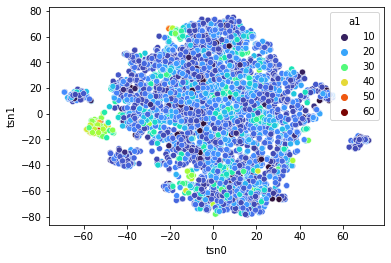

In [45]:
np.shape(S_t_sne)

dfx["tsn0"] = S_t_sne[:,0]
dfx["tsn1"] = S_t_sne[:,1]

sns.scatterplot(data=dfx,x="tsn0", y="tsn1", hue="a1",palette=plt.cm.turbo)

### 10. Stwórz macierz dystansu dla wektorowej reprezentacji repertuaru

In [46]:
dismat= pd.DataFrame(
    squareform(pdist(dfx[["tcra_aa_len", "tcrb_aa_len", "a1", "b1", "a2", "b2", "a3", "b3", "a4", "b4", "a5", "b5"]])),
    columns = dfx.index,
    index = dfx.index
)

### 11. Dokonaj grupowania wektorowej reprezentacji repertuaru w oparciu o macierz stworzoną w poprzednim kroku. Wyniki zaprezentuj na wykresie.

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Użyj tych samych metod co wcześniej. 
</div>


In [47]:
clustering = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold =1900 ).fit_predict(dismat)

C:\Users\mateuszt\AppData\Roaming\Python\Python38\site-packages\scipy\cluster\hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [48]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

turbo = cm.get_cmap('turbo', len(set(clustering)))
print(len(turbo.colors))

34


In [49]:
lut = dict(zip(list(set(clustering)), np.linspace(0, 1, 34)))
row_colors = np.vectorize(lut.get)(clustering)

c:\program files\python38\lib\site-packages\seaborn\matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\program files\python38\lib\site-packages\seaborn\matrix.py:629: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


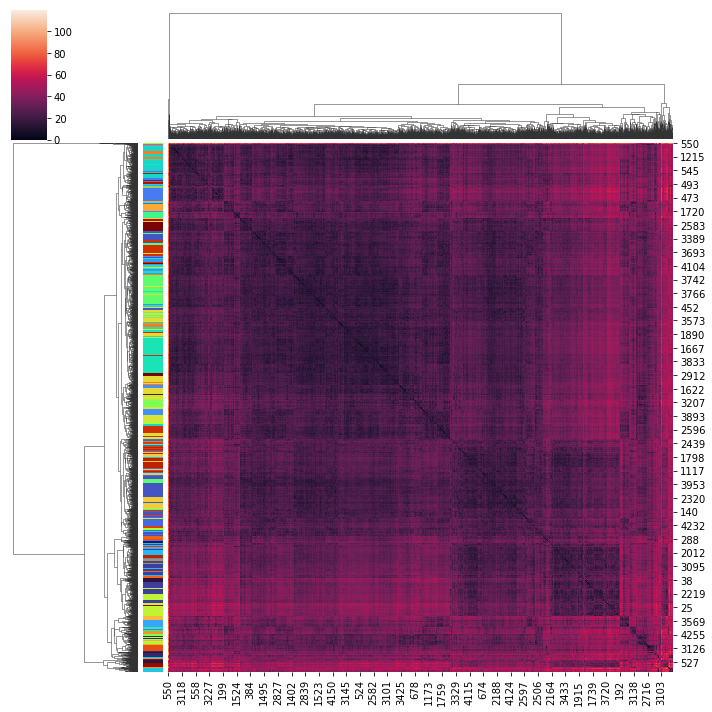

In [50]:
sns.clustermap(dismat, row_colors=turbo(row_colors))

In [51]:
dfx['clustering']=clustering

### 12. Oznacz na projekcji repertuaru wygenerowane grupy (klastry) przy użyciu różnych kolorów

<AxesSubplot:xlabel='tsn0', ylabel='tsn1'>

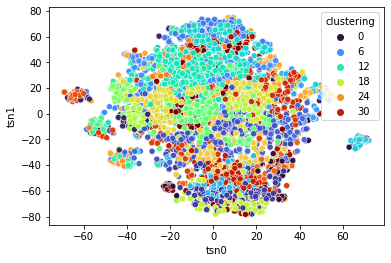

In [52]:
sns.scatterplot(data=dfx,x="tsn0", y="tsn1", hue="clustering",palette=plt.cm.turbo)

### 13. Stwórz graf podobieństwa dla reperuatu w oparciu o macierz dystansu wygenerowaną na podstawie odległości pomiędzy sekwencjami receptorów.

In [53]:
print(np.count_nonzero((dist2<20) & (dist2>0)))

34


In [54]:
rero = np.where((dist2<20) & (dist2>0))

In [55]:
d = {'r1': rero[0], 'r2': rero[1]}
df_rero = pd.DataFrame(data=d)

In [56]:
df_rero

,r1,r2
0,1,273
1,34,194
2,85,166
3,86,194
4,88,261
5,140,166
6,163,236
7,166,85
8,166,140
9,166,285


In [57]:
G = nx.from_pandas_edgelist(df_rero, source='r1', target='r2')

<ipython-input-58-67e3f92e6a5c>:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


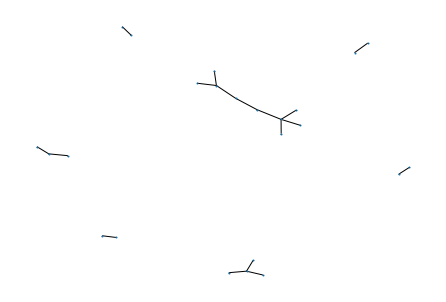

In [58]:
pos = nx.spring_layout(G)  # positions for all nodes - seed for reproducibi

# nodes
#nx.draw_networkx_nodes(G, pos, node_size=1)

# edges
nx.draw(G, pos, node_size=1, width=1)  # using a 10x scale factor here

# labels
nx.draw_networkx_labels(G, pos, font_size=1, font_family="sans-serif")
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.savefig("plotnet1.pdf")

### 14. Stwórz graf podobieństwa dla reperuatu w oparciu o macierz dystansu wygenerowaną na podstawie wektorów numerycznych.

In [59]:
print(np.count_nonzero((dismat[:300][:300]<7) & (dismat[:300][:300]>0)))

72


In [60]:
veco = np.where((dismat[:300][:300]<8) & (dismat[:300][:300]>0))

In [61]:
dve = {'r1': veco[0], 'r2': veco[1]}
df_veco = pd.DataFrame(data=dve)

In [62]:
Gv = nx.from_pandas_edgelist(df_veco, source='r1', target='r2')

<ipython-input-63-5c7872199b7b>:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


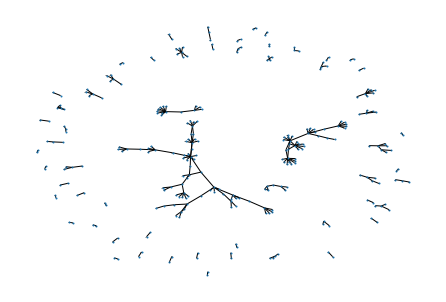

In [63]:
pos = nx.spring_layout(Gv)  # positions for all nodes - seed for reproducibi

# nodes
#nx.draw_networkx_nodes(G, pos, node_size=1)

# edges
nx.draw(Gv, pos, node_size=1, width=1)  # using a 10x scale factor here

# labels
nx.draw_networkx_labels(Gv, pos, font_size=1, font_family="sans-serif")
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.savefig("plotnet2.pdf")

### 18. Opisz i porównaj grafy 

<div class="alert alert-block alert-info">
<b>Wskazówka:</b> Przeanalizuj perkolacje w grafie. Jak zmienia się rozkład wielkości składowych sieci wraz ze zmianą progu dla tworzenia połączeń między węzłami? Jak zmienia się średnia konektywność węzłów? Jaki próg podobieństwa receptorów jest najlepszy dla tworzenia połączeń w grafie? Który z grafów jest Twoim zdaniem lepszy do analizy?
</div>


<div class="alert alert-block alert-info">
<b>Dla zainteresowanych:</b> Porównaj miary z wygenerowanym losowo grafem. Jaki algorytm generowania grafów będzie najlepszy do tego?
</div>


In [65]:
nx.average_node_connectivity(G)

0.17753623188405798

In [66]:
nx.k_components(G)

{1: [{1, 273},
  {34, 86, 163, 171, 175, 194, 215, 236, 297},
  {85, 140, 166, 285},
  {88, 261},
  {174, 251},
  {190, 246, 250},
  {212, 218}]}

1
2
3
4
5
6
7
8


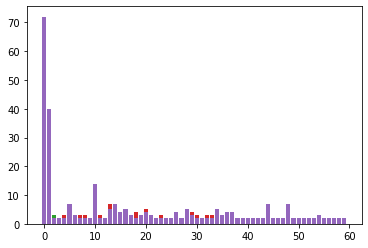

In [67]:
#avg_gv_conn = []
comliGv = []
for ci in range(1,9):
    print(ci)
    veco = np.where((dismat[:300][:300]<ci) & (dismat[:300][:300]>0))
    dve = {'r1': veco[0], 'r2': veco[1]}
    df_veco = pd.DataFrame(data=dve)
    Gv = nx.from_pandas_edgelist(df_veco, source='r1', target='r2')
    if(np.count_nonzero((dismat[:300][:300]<ci) & (dismat[:300][:300]>0))>0):
        for scompo in nx.k_components(Gv)[1]:
            #print(nx.k_components(Gv))
            comliGv.append(len(scompo))
        plt.bar(np.arange(len(comliGv)), comliGv)
        comliGv = []
    #avg_gv_conn.append(nx.average_node_connectivity(Gv))

23


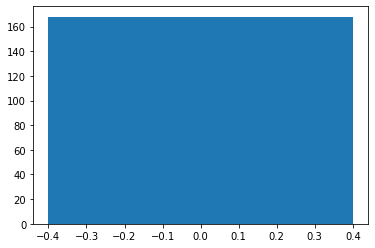

In [69]:
comliG = []
avg_g_conn = []
for ci in range(23,24):
    print(ci)
    rero = np.where((dist2<ci) & (dist2>0))
    d = {'r1': rero[0], 'r2': rero[1]}
    df_rero = pd.DataFrame(data=d)
    G = nx.from_pandas_edgelist(df_rero, source='r1', target='r2')
   # avg_g_conn.append(nx.average_node_connectivity(G))
    if(np.count_nonzero((dist2<ci) & (dist2>0))>0):
        for scompo in nx.k_components(G)[1]:
                #print(nx.k_components(Gv))
                comliG.append(len(scompo))
        plt.bar(np.arange(len(comliG)), comliG)
        comliG = []

In [70]:
avg_g_conn

[]

In [ ]:
### 15. Zmapuj receptory na antygeny (epitopy) - wykorzystaj do tego TCRmatch lub NetTCR

In [ ]:
### 16. Zmapuj zwektoryzowaną reprezentacje par receptor - antygen na 2 lub 3 wymiarową przestrzeń 

In [ ]:
### 17. Opracuj graf podovbieństwa receptorów w oparciu o zmapowane antygeny

In [ ]:
### 18. Opisz i porównaj grafy 